# Code for competition

In [28]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import shutil
from collections import Counter
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from PIL import Image
from tensorflow.keras.applications.xception import preprocess_input 
import zipfile

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
print(tf.config.list_physical_devices())

# Enable experimental feature of memory occupation growth control 
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for dev in physical_devices:
    tf.config.experimental.set_memory_growth(dev, True)

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.10.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Metadata

In [29]:
input_shape = (96, 96, 3)
input_size = input_shape[:-1]
batch_size = 64
epochs = 400
classes = ["Species1", "Species2", "Species3", "Species4", "Species5", "Species6", "Species7", "Species8"]

### Prepare the environment

In [30]:
train_split = 0.85

path = os.getcwd()
if not os.path.exists(path+'/training') and not os.path.exists(path+'/validation'):
    os.mkdir(path+'/training')
    os.mkdir(path+'/validation')

    # Destination path 
    dest_train = path + '/training'
    dest_valid = path + '/validation'

    # Source path
    source = path + '/training_data_final'

    # Create train and validation into the training and validation folders
    for folder in os.listdir(source):
        if not os.path.exists(dest_train + '/' + folder):
            os.mkdir(dest_train + '/' + folder)
        if not os.path.exists(dest_valid + '/' + folder):
            os.mkdir(dest_valid + '/' + folder)
    
        class_source = source + '/' + folder                                                   # Create path of the class
        files = os.listdir(class_source)                                                       # List of files for the class
        random.shuffle(files)
        
        # Create training set randomly
        for i in range(int(len(files) * train_split)):
            dest = shutil.copy(class_source+'/'+files[i], dest_train+'/'+folder+'/'+files[i])  # Copy an image in the training set
        
        # Create validation set randomly
        for j in range(i + 1, len(files)):
            dest = shutil.copy(class_source+'/'+files[j], dest_valid+'/'+folder+'/'+files[j])  # copy an image in the validation set

### Prepare the validation set for evaluation purposes

In [31]:
samples = []
targets = []

dest_valid = os.getcwd() + '/validation'

i=0
for folder in os.listdir(dest_valid):
    dest_class = dest_valid + '/' + folder
    for img in os.listdir(dest_class):
        temp = Image.open(dest_class + '/' + img).convert('RGB')
        image = np.squeeze(np.expand_dims(temp, axis=0))
        label = tfk.utils.to_categorical(i, len(classes))
        samples.append(image)
        targets.append(label)
    i += 1

X_val = np.array(samples)
y_val = np.array(targets, dtype=np.uint8)
print(X_val.shape, X_val.dtype, sep=", ")
print(y_val.shape, y_val.dtype, sep=", ")

# Compute the class weights in order to balance loss during training
y_numeric = []
for v in y_val:
    y_numeric.append(np.argmax(v))

labels = np.unique(np.fromiter([np.argmax(t) for t in y_val], np.int32))

(535, 96, 96, 3), uint8
(535, 8), uint8


###Load training set to perform standardization during training

In [32]:
samples = []
targets = []

dest_train = os.getcwd() + '/training'

i=0
for folder in os.listdir(dest_train):
    dest_class = dest_train + '/' + folder
    for img in os.listdir(dest_class):
        temp = Image.open(dest_class + '/' + img).convert('RGB')
        image = np.squeeze(np.expand_dims(temp, axis=0))
        label = tfk.utils.to_categorical(i, len(classes))
        samples.append(image)
        targets.append(label)
    i += 1
X_train = np.array(samples)
y_train = np.array(targets, dtype=np.uint8)
print(X_train.shape, X_train.dtype, sep=", ")
print(y_train.shape, y_train.dtype, sep=", ")


(3007, 96, 96, 3), uint8
(3007, 8), uint8


### Static training set imbalance to perform oversampling of minority class (NO AUGMENTATION HERE)

In [33]:
balanced = False #If true, training set will be inflated to get same amount of samples from each class. 
                # If false, training will imbalance the trainingset to get a sampling frequency that matches class_weights
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=y_numeric)))
class_weights = dict(enumerate([5.,1.,1.,1.,1.,3.,1.,5.]))
print(class_weights)

if  not os.path.exists(path+'/training_aug'):
    old_train = os.getcwd() + '/training'
    dest_train = os.getcwd() + '/training_aug'
    shutil.copytree(old_train, dest_train) #Copy the previous training set folder images into new inflated training folder

    static_gen = ImageDataGenerator()
    #find folder with largest number of samples
    folder_sizes = []
    for folder in os.listdir(dest_train):
        dest_path = dest_train + '/' + folder
        folder_sizes.append(len(os.listdir(dest_path)))
    print(folder_sizes)
    desired_amount = np.max(folder_sizes)
    print("Target: "+ str(desired_amount) + " images per class")
    label = 0
    for folder in os.listdir(dest_train):
        dest_path = dest_train + '/' + folder

        if balanced:
            to_produce = desired_amount - len(os.listdir(dest_path))
        else:
            to_produce = desired_amount - len(os.listdir(dest_path)) + int((class_weights[label] - 1) * desired_amount)
        
        static_gen_data = static_gen.flow_from_directory(dest_train,
                                                        batch_size=1,
                                                        target_size=input_size,
                                                        classes=[folder],
                                                        class_mode='categorical',      # Targets are directly converted into one-hot vectors
                                                        shuffle=False, #??????
                                                        seed=seed) 

        print(f'Computing {to_produce} augmented images for target "{folder}"')
        os.chdir(dest_path)
        for i in range(0, to_produce):
            Image.fromarray(np.squeeze(next(static_gen_data)[0]).astype(np.uint8)).save(f'aug{i:05}.jpg')
        os.chdir('../')
        label += 1

    os.chdir('../')
    print('\n' + os.getcwd())

{0: 5.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 3.0, 6: 1.0, 7: 5.0}


### Online augmentation
Lets create the generators we'll need...

In [34]:
#Apply online augmentation and apply network's preprocessing function

train_data_gen = ImageDataGenerator(rotation_range = 90,
                                    height_shift_range = 30,
                                    width_shift_range = 30,
                                    horizontal_flip = True,
                                    zoom_range=[0.7,1.5], # added zoom range
                                    fill_mode = 'reflect',
                                    featurewise_center=True, 
                                    featurewise_std_normalization=True,
                                    preprocessing_function = preprocess_input)
train_data_gen.fit(preprocess_input(X_train)) #Fit the training generator to the non augmented training set to learn mean and std
valid_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                    featurewise_center=True, 
                                    featurewise_std_normalization=True)
valid_data_gen.fit(preprocess_input(X_train))
print(train_data_gen.mean,train_data_gen.std)

[[[-0.3034819  -0.25158027 -0.29118094]]] [[[0.41523662 0.41974235 0.41063303]]]


... using flow_from_directory

In [35]:
# Paths
path = os.getcwd()
training_dir = path + '/training_aug'
validation_dir = path + '/validation'

# Training
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               batch_size=batch_size,
                                               target_size=input_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=seed)  

# Validation
valid_gen = valid_data_gen.flow_from_directory(validation_dir,
                                               batch_size=batch_size, 
                                               target_size=input_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=seed)

# Create Datasets objects
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.uint8),
                                               output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], [None, len(classes)]))

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.uint8),
                                               output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], [None, len(classes)]))

valid_dataset = valid_dataset.repeat()

Found 7296 images belonging to 8 classes.
Found 535 images belonging to 8 classes.


### Build the supernet model for tuning

In [36]:
def build_supernet_model(input_shape):
    tf.random.set_seed(seed)

    #Load the supernet
    supernet = tfk.applications.Xception(include_top=False,
                                            weights="imagenet",
                                            input_shape=input_shape)
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    #x = tfkl.Resizing(144, 144, interpolation="bicubic", name='resizing')(input_layer)

    x = supernet(input_layer)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    output_layer = tfkl.Dense(
        units = len(labels), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'conv_dense_model_v1_online')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

    # Return the model
    return model

### Define the model

In [37]:
model = build_supernet_model(input_shape)
# Enable the tuning to the whole supernet 
model.get_layer('xception').trainable = True
model.summary()

Model: "conv_dense_model_v1_online"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 gap (GlobalAveragePooling2D  (None, 2048)             0         
 )                                                               
                                                                 
 output_layer (Dense)        (None, 8)                 16392     
                                                                 
Total params: 20,877,872
Trainable params: 20,823,344
Non-trainable params: 54,528
_________________________________________________________________


### Train the model

In [38]:
#exponential decay for the learning rate
initial_lr = 5e-4 # suggested 5e-5 for transfer learning applications
def scheduler(epoch, lr):
    if epoch <= 10:
        return initial_lr
    else:
        return max(initial_lr * tf.math.exp(- (epoch-10) / 10.0), 1e-5)

# Train the network
history = model.fit(x=train_dataset,
                    epochs=epochs,                                    
                    steps_per_epoch=int(len(X_train)/batch_size),   # 1 epoch will be considered as 1 pass over the training augmented dataset. Thanks to inflation of training set we perform oversampling
                    validation_data=valid_dataset,
                    validation_steps=len(valid_gen),
                    #class_weight=class_weights,                       #Class weights not used in the loss function during supernet tuning
                    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
                                 tfk.callbacks.LearningRateScheduler(scheduler)]
).history

Epoch 1/400


KeyboardInterrupt: 

### Plot training results

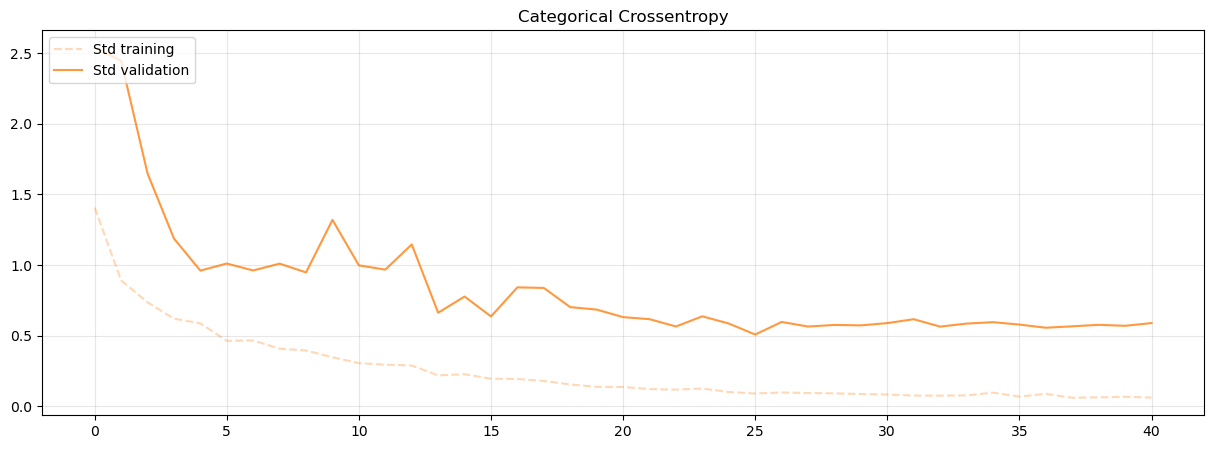

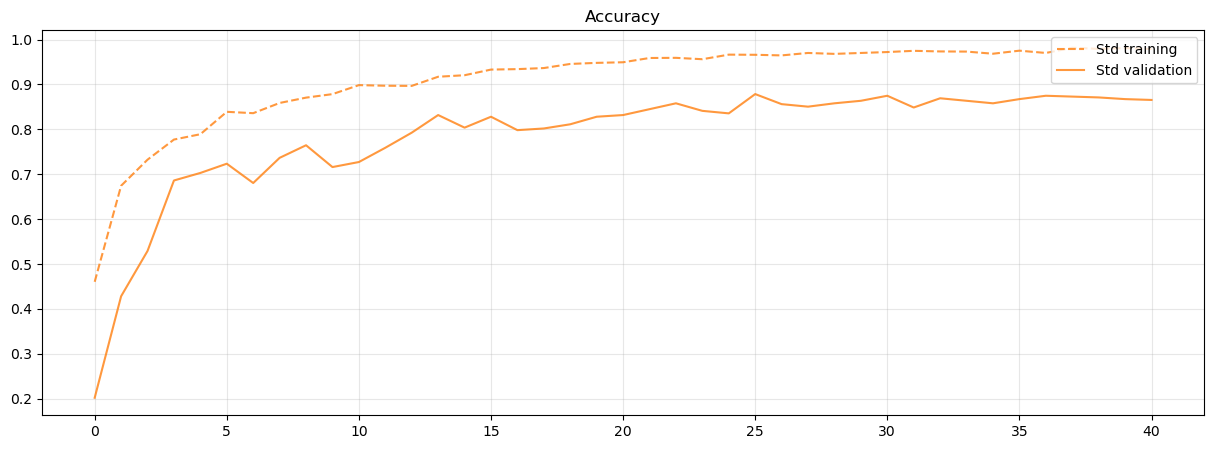

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Std training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Std training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Plot the confusion matrix (evaluated on the validation set)

9/9 [==============================] - 1s 77ms/step
Accuracy: 0.8785
Precision: 0.8907
Recall: 0.8305
F1: [0.5128 0.8814 0.956  0.8679 0.898  0.8438 0.9487 0.8284]


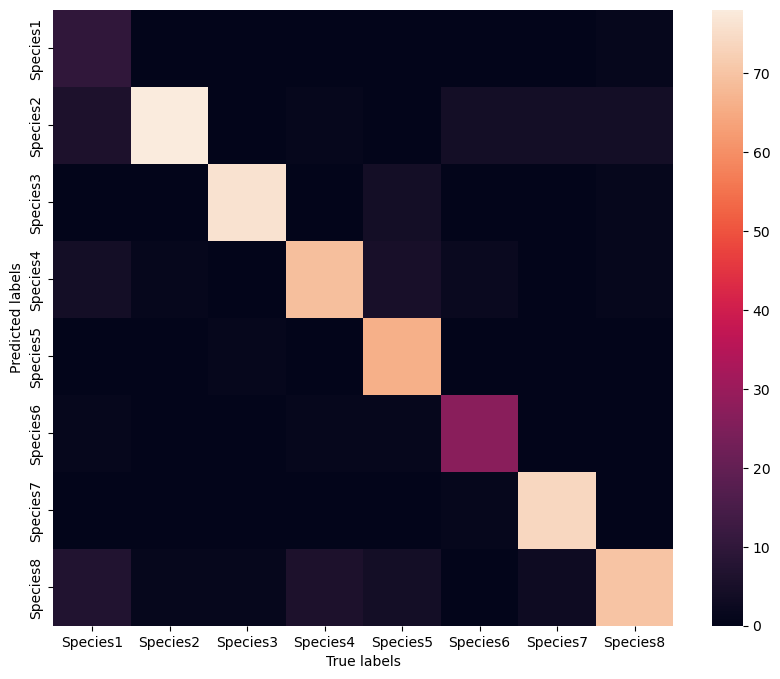

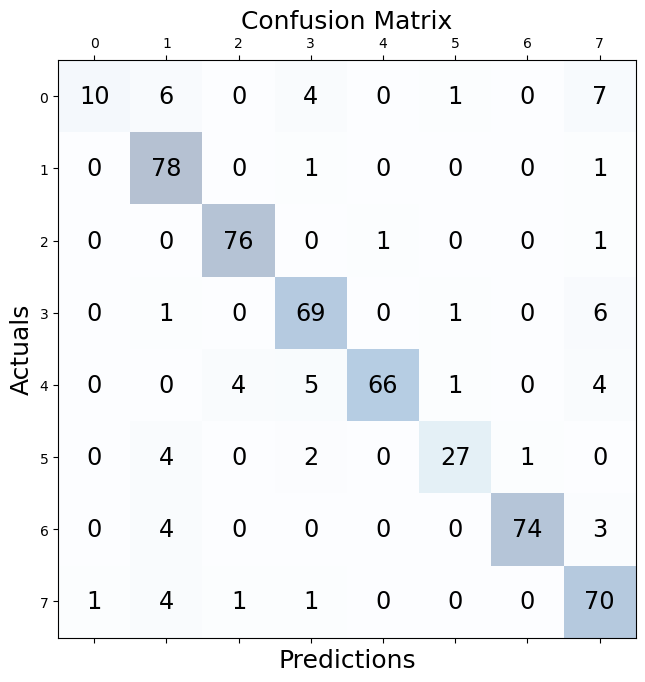

In [ ]:
predictions = model.predict(valid_dataset,steps= len(valid_gen))
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average=None)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=classes, yticklabels=classes)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Print the confusion matrix using Matplotlib
conf_matrix = confusion_matrix(y_true=np.argmax(y_val, axis=-1), y_pred= np.argmax(predictions, axis=-1))
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### Save the model

In [ ]:
model.save('supernet_tuned_model')

INFO:tensorflow:Assets written to: supernet_tuned_model\assets


INFO:tensorflow:Assets written to: supernet_tuned_model\assets


### Build the final classifier

In [ ]:
def build_classifier_model(input_shape):
    tf.random.set_seed(seed)

    # Load the supernet
    supernet = tfk.applications.Xception(include_top=False,
                                            input_shape=input_shape)

    # Recover previous weights
    supernet.set_weights(tfk.models.load_model('supernet_tuned_model').get_layer('xception').get_weights())
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    x = supernet(input_layer)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    
    x_gap = x

    x = tfkl.Dense(
        units = 2048,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'classifier2')(x)

    #x = tfkl.Dropout(0.2, seed=seed, name='dropout')(x)

    # Skip connection
    x = tfkl.Add()([x_gap, x])
    
    output_layer = tfkl.Dense(
        units = len(classes), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'classifier_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(2e-4), metrics='accuracy')

    # Return the model
    return model

In [ ]:
classifier_model = build_classifier_model(input_shape)

# Use the supernet as a pretrained feature extraction net (and apply eventual fine tuning)
classifier_model.get_layer('xception').trainable = True
for i, layer in enumerate(classifier_model.get_layer('xception').layers[:-5]):
  layer.trainable=False
for i, layer in enumerate(classifier_model.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)  

classifier_model.summary()

0 input_7 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d_24 False
13 block2_pool False
14 batch_normalization_24 False
15 add_74 False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_25 False
23 block3_pool False
24 batch_normalization_25 False
25 add_75 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_26 False
33 block4_pool False
34 batch_normalization_26 False
35 add_76 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5

In [ ]:
train_mul = 1

# define learning rate scheduler parameters
high_period = 5
medium_period = 10
low_period = 5
high_lr= 5e-4  
medium_lr = 1e-4
low_lr = 2e-5

def scheduler(epoch, lr):
    global high_lr
    global medium_lr
    #convergence factor to shrink high and medium values onto low_lr over time
    tot_period = high_period + medium_period + low_period + medium_period
    if epoch % (tot_period) == (tot_period - 1):
        high_lr = max(high_lr * tf.math.exp(-0.1), low_lr)
        medium_lr = max(medium_lr * tf.math.exp(-0.1), low_lr)

    if epoch % (tot_period) < high_period:
        return high_lr
    elif epoch % (tot_period) < high_period + medium_period:
        return medium_lr    
    elif epoch % (tot_period) < high_period + medium_period + low_period:
        return low_lr    
    return medium_lr


class_weights = dict(enumerate([5., 1., 1., 1., 1., 5., 1., 1.5])) #redefine class weights to improve misspredictions on worst performing classes
classifier_history = classifier_model.fit(x=train_dataset,
                                          epochs=epochs,                                  
                                          steps_per_epoch=int(len(train_gen) * train_mul),
                                          validation_data=valid_dataset,
                                          validation_steps=len(valid_gen),
                                          class_weight=class_weights,
                                          callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=25, restore_best_weights=True),
                                                       tfk.callbacks.LearningRateScheduler(scheduler)]
).history

Epoch 1/400
114/114 [==============================] - 27s 201ms/step - loss: 0.5088 - accuracy: 0.9064 - val_loss: 2.5474 - val_accuracy: 0.6430 - lr: 5.0000e-04
Epoch 2/400
114/114 [==============================] - 22s 194ms/step - loss: 0.5161 - accuracy: 0.9028 - val_loss: 1.2232 - val_accuracy: 0.7458 - lr: 5.0000e-04
Epoch 3/400
 37/114 [========>.....................] - ETA: 14s - loss: 0.4319 - accuracy: 0.9143

KeyboardInterrupt: 

### Plot training results

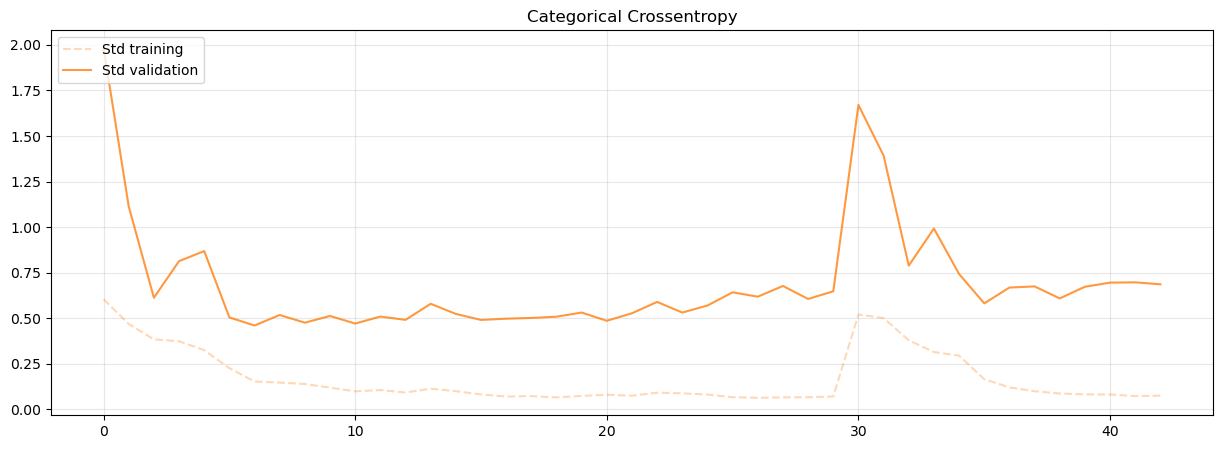

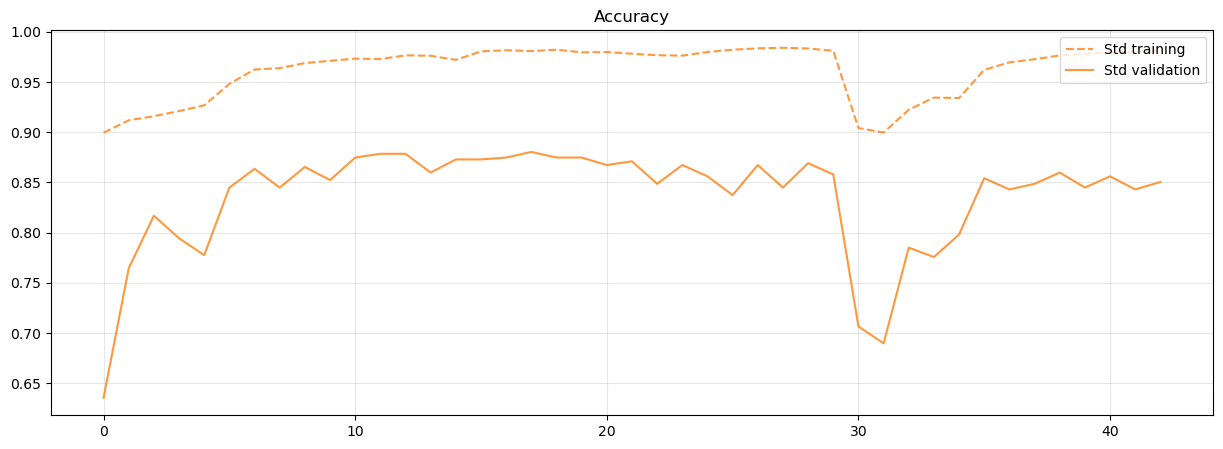

In [ ]:
history = classifier_history

plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Std training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Std training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Plot the confusion matrix (evaluated on the validation set)

9/9 [==============================] - 1s 81ms/step
Accuracy: 0.8804
Precision: 0.8651
Recall: 0.8328
F1: [0.4889 0.8914 0.9281 0.8519 0.929  0.8387 0.9299 0.882 ]


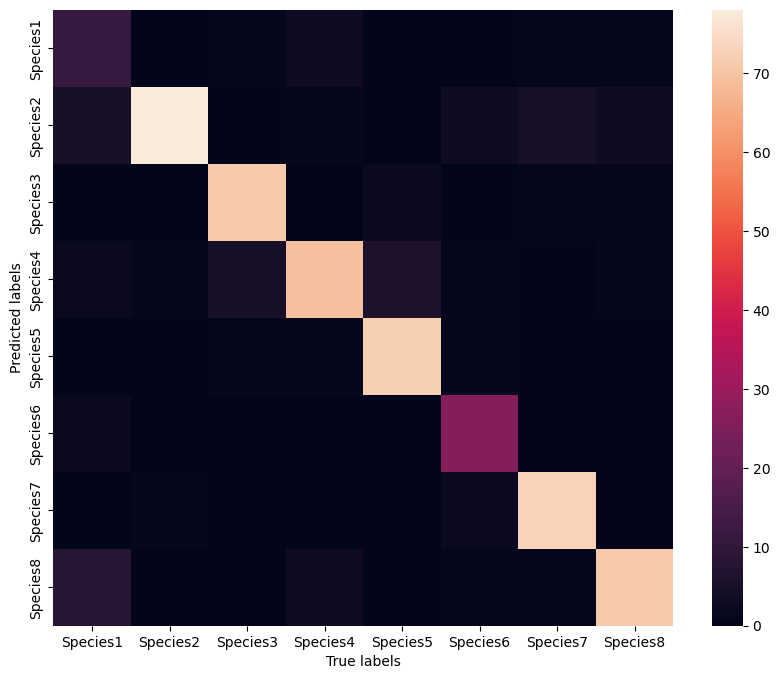

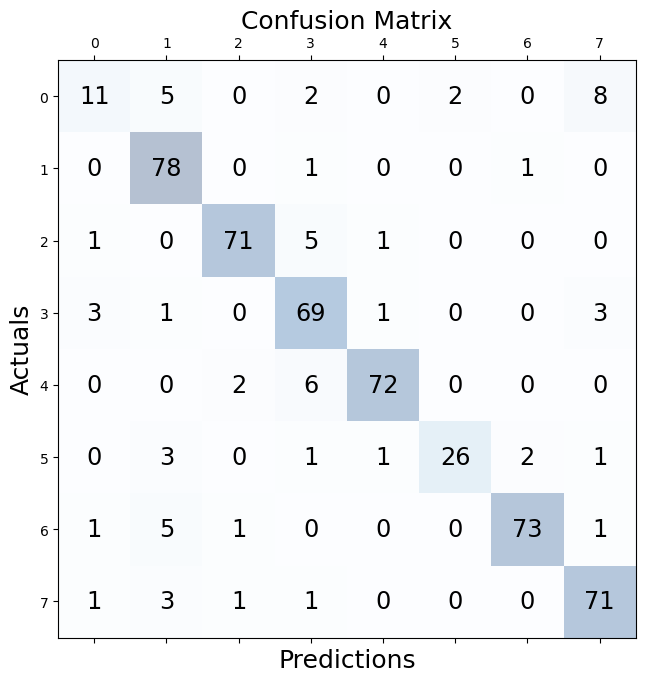

In [ ]:
predictions = classifier_model.predict(valid_dataset,steps= len(valid_gen))
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average=None)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=classes, yticklabels=classes)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Print the confusion matrix using Matplotlib
conf_matrix = confusion_matrix(y_true=np.argmax(y_val, axis=-1), y_pred= np.argmax(predictions, axis=-1))
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### Save the model

In [ ]:
classifier_model.save('best_model_classifier')


KeyboardInterrupt: 